tgb - 4/15/2020
- Adapting Ankitesh's notebook that builds and train a "brute-force" network to David Walling's hyperparameter search  
- Adding the option to choose between aquaplanet and real-geography data

In [1]:
import sys
sys.path.insert(1,"/home1/07064/tg863631/anaconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages") #work around for h5py
from cbrain.imports import *
from cbrain.cam_constants import *
from cbrain.utils import *
from cbrain.layers import *
from cbrain.data_generator import DataGenerator

import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)
tf.config.experimental.set_memory_growth(physical_devices[2], True)

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from tensorflow import math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow_probability as tfp
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin
# import cartopy.crs as ccrs
import matplotlib.ticker as mticker
# from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pickle
# from climate_invariant import *
from tensorflow.keras import layers
import datetime
from climate_invariant_utils import *
import yaml


/nfspool-0/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog


## Global Variables

In [2]:
# Load coordinates (just pick any file from the climate model run)

# Comet path below
# coor = xr.open_dataset("/oasis/scratch/comet/ankitesh/temp_project/data/sp8fbp_minus4k.cam2.h1.0000-01-01-00000.nc",\
#                     decode_times=False)

# GP path below
path_0K = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/fluxbypass_aqua/'
coor = xr.open_dataset(path_0K+"AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-09-02-00000.nc")

lat = coor.lat; lon = coor.lon; lev = coor.lev;
coor.close();

In [3]:
# Comet path below
# TRAINDIR = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/CRHData/'
# path = '/home/ankitesh/CBrain_project/CBRAIN-CAM/cbrain/'

# GP path below
TRAINDIR = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'
path = '/export/nfs0home/tbeucler/CBRAIN-CAM/cbrain/'
path_nnconfig = '/export/nfs0home/tbeucler/CBRAIN-CAM/nn_config/'

# Load hyam and hybm to calculate pressure field in SPCAM
path_hyam = 'hyam_hybm.pkl'
hf = open(path+path_hyam,'rb')
hyam,hybm = pickle.load(hf)

# Scale dictionary to convert the loss to W/m2
scale_dict = load_pickle(path_nnconfig+'scale_dicts/009_Wm2_scaling.pkl')

New Data generator class for the climate-invariant network. Calculates the physical rescalings needed to make the NN climate-invariant

In [4]:
class DataGeneratorClimInv(DataGenerator):
    
    def __init__(self, data_fn, input_vars, output_vars,
             norm_fn=None, input_transform=None, output_transform=None,
             batch_size=1024, shuffle=True, xarray=False, var_cut_off=None,
             rh_trans=True,t2tns_trans=True,
             lhflx_trans=True,
             scaling=True,interpolate=True,
             hyam=None,hybm=None,                 
             inp_subRH=None,inp_divRH=None,
             inp_subTNS=None,inp_divTNS=None,
             lev=None, interm_size=40,
             lower_lim=6,
             is_continous=True,Tnot=5,
                mode='train',portion=1):
        
        self.scaling = scaling
        self.interpolate = interpolate
        self.rh_trans = rh_trans
        self.t2tns_trans = t2tns_trans
        self.lhflx_trans = lhflx_trans
        self.inp_shape = 64
        self.mode=mode
        super().__init__(data_fn, input_vars,output_vars,norm_fn,input_transform,output_transform,
                        batch_size,shuffle,xarray,var_cut_off) ## call the base data generator
        self.inp_sub = self.input_transform.sub
        self.inp_div = self.input_transform.div
        if rh_trans:
            self.qv2rhLayer = QV2RHNumpy(self.inp_sub,self.inp_div,inp_subRH,inp_divRH,hyam,hybm)
        
        if lhflx_trans:
            self.lhflxLayer = LhflxTransNumpy(self.inp_sub,self.inp_div,hyam,hybm)
            
        if t2tns_trans:
            self.t2tnsLayer = T2TmTNSNumpy(self.inp_sub,self.inp_div,inp_subTNS,inp_divTNS,hyam,hybm)
            
        if scaling:
            self.scalingLayer = ScalingNumpy(hyam,hybm)
            self.inp_shape += 1
                    
        if interpolate:
            self.interpLayer = InterpolationNumpy(lev,is_continous,Tnot,lower_lim,interm_size)
            self.inp_shape += interm_size*2 + 4 + 30 ## 4 same as 60-64 and 30 for lev_tilde.size
            
        # tgb - 7/9/2020 - Test only training on a subset of the data determined by portion
        self.portion = portion
            
        
    def __getitem__(self, index):
        
        # If portion<1, only look at a subset of the data by putting an upper bound on index
        if self.portion<1: index = index % round(1/self.portion)
        elif self.portion>1: print('Setting portion=1 because portion>1')
        elif self.portion<0: print('Setting portion=1 because portion<0')
        
        # Compute start and end indices for batch
        start_idx = index * self.batch_size
        end_idx = start_idx + self.batch_size

        # Grab batch from data
        batch = self.data_ds['vars'][start_idx:end_idx]

        # Split into inputs and outputs
        X = batch[:, self.input_idxs]
        Y = batch[:, self.output_idxs]
        # Normalize
        X_norm = self.input_transform.transform(X)
        Y = self.output_transform.transform(Y)
        X_result = X_norm
        
        if self.rh_trans:
            X_result = self.qv2rhLayer.process(X_result) 
            
        if self.lhflx_trans:
            X_result = self.lhflxLayer.process(X_result)
            X_result = X_result[:,:64]
            X = X[:,:64]
            
        if self.t2tns_trans:
            X_result = self.t2tnsLayer.process(X_result)
        
        if self.scaling:
            scalings = self.scalingLayer.process(X) 
            X_result = np.hstack((X_result,scalings))
        
        if self.interpolate:
            interpolated = self.interpLayer.process(X,X_result)
            X_result = np.hstack((X_result,interpolated))
            

        if self.mode=='val':
            return xr.DataArray(X_result), xr.DataArray(Y)
        return X_result,Y
    
    ##transforms the input data into the required format, take the unnormalized dataset
    def transform(self,X):
        X_norm = self.input_transform.transform(X)
        X_result = X_norm
        
        if self.rh_trans:
            X_result = self.qv2rhLayer.process(X_result)  
        
        if self.lhflx_trans:
            X_result = self.lhflxLayer.process(X_result)
            X_result = X_result[:,:64]
            X = X[:,:64]

        if self.t2tns_trans:
            X_result = self.t2tnsLayer.process(X_result)
        
        if self.scaling:
            scalings = self.scalingLayer.process(X) 
            X_result = np.hstack((X_result,scalings))
        
        if self.interpolate:
            interpolated = self.interpLayer.process(X,X_result)
            X_result = np.hstack((X_result,interpolated))
            

        return X_result

## Data Generators

### Choose between aquaplanet and realistic geography here

In [5]:
# GP paths below
path_aquaplanet = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'
path_realgeography = ''

# Comet paths below
# path_aquaplanet = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'
# path_realgeography = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/geography/'

path = path_aquaplanet

### Baseline Data Generator, without ozone as input but with radiative outputs

In [6]:
in_vars = ['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
if path==path_aquaplanet: out_vars = ['PHQ','TPHYSTND','QRL', 'QRS']
elif path==path_realgeography: out_vars = ['PTEQ','PTTEND','FSNT','FSNS','FLNT','FLNS']

TRAINFILE_O3 = '2021_01_24_O3_TRAIN_shuffle.nc'
NORMFILE_O3 = '2021_01_24_NORM_O3_small.nc'
VALIDFILE_O3 = '2021_01_24_O3_VALID.nc'
TESTFILE_O3 = '2021_01_24_O3_TEST.nc'

In [7]:
train_gen_noO3 = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE_O3,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE_O3,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=8192,
    shuffle=True
)

In [8]:
valid_gen_noO3 = DataGenerator(
    data_fn = TRAINDIR+VALIDFILE_O3,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE_O3,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=8192,
    shuffle=True
)

In [9]:
test_gen_noO3 = DataGenerator(
    data_fn = TRAINDIR+TESTFILE_O3,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE_O3,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=8192,
    shuffle=True
)

### Data Generator using RH

In [6]:
scale_dict_RH = load_pickle('/home/ankitesh/CBrain_project/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_scaling_2.pkl')
scale_dict_RH['RH'] = 0.01*L_S/G, # Arbitrary 0.1 factor as specific humidity is generally below 2%

in_vars_RH = ['RH','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
if path==path_realgeography: out_vars_RH = ['PTEQ','PTTEND','FSNT','FSNS','FLNT','FLNS']
elif path==path_aquaplanet: out_vars_RH = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

TRAINFILE_RH = 'CI_RH_M4K_NORM_train_shuffle.nc'
NORMFILE_RH = 'CI_RH_M4K_NORM_norm.nc'
VALIDFILE_RH = 'CI_RH_M4K_NORM_valid.nc'

In [7]:
train_gen_RH = DataGenerator(
    data_fn = path+TRAINFILE_RH,
    input_vars = in_vars_RH,
    output_vars = out_vars_RH,
    norm_fn = path+NORMFILE_RH,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_RH,
    batch_size=1024,
    shuffle=True,
)

### Data Generator using TNS

In [8]:
in_vars = ['QBP','TfromNS','PS', 'SOLIN', 'SHFLX', 'LHFLX']
if path==path_aquaplanet: out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']
elif path==path_realgeography: out_vars = ['PTEQ','PTTEND','FSNT','FSNS','FLNT','FLNS']

TRAINFILE_TNS = 'CI_TNS_M4K_NORM_train_shuffle.nc'
NORMFILE_TNS = 'CI_TNS_M4K_NORM_norm.nc'
VALIDFILE_TNS = 'CI_TNS_M4K_NORM_valid.nc'

In [9]:
train_gen_TNS = DataGenerator(
    data_fn = path+TRAINFILE_TNS,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path+NORMFILE_TNS,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
)

### Data Generator using $O_{3}$

In [39]:
in_vars = ['QBP','TBP','O3_AQUA','PS', 'SOLIN', 'SHFLX', 'LHFLX']
if path==path_aquaplanet: out_vars = ['PHQ','TPHYSTND','QRL', 'QRS']
elif path==path_realgeography: out_vars = ['PTEQ','PTTEND','FSNT','FSNS','FLNT','FLNS']

TRAINFILE_O3 = '2021_01_24_O3_TRAIN_shuffle.nc'
NORMFILE_O3 = '2021_01_24_NORM_O3_small.nc'
VALIDFILE_O3 = '2021_01_24_O3_VALID.nc'
TESTFILE_O3 = '2021_01_24_O3_TEST.nc'

In [40]:
train_gen_O3 = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE_O3,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE_O3,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=8192,
    shuffle=True
)

In [41]:
valid_gen_O3 = DataGenerator(
    data_fn = TRAINDIR+VALIDFILE_O3,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE_O3,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=8192,
    shuffle=True
)

In [42]:
test_gen_O3 = DataGenerator(
    data_fn = TRAINDIR+TESTFILE_O3,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE_O3,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=8192,
    shuffle=True
)

### Data Generator Combined

In [10]:
in_vars = ['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
if path==path_aquaplanet: out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']
elif path==path_realgeography: out_vars = ['PTEQ','PTTEND','FSNT','FSNS','FLNT','FLNS']

In [11]:
TRAINFILE = 'CI_SP_M4K_train_shuffle.nc'
NORMFILE = 'CI_SP_M4K_NORM_norm.nc'
VALIDFILE = 'CI_SP_M4K_valid.nc'

train_gen = DataGeneratorClimInv(
    data_fn = path+TRAINFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
    inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div,
    rh_trans=False,t2tns_trans=False,
    lhflx_trans=False,
    scaling=False,
    interpolate=False
)

valid_gen = DataGeneratorClimInv(
    data_fn = path+VALIDFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
    inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div,
    rh_trans=False,t2tns_trans=False,
    lhflx_trans=False,
    scaling=False,
    interpolate=False
)


### Check number of samples for Griffin

In [12]:
data = xr.open_dataset(path+TRAINFILE)

In [13]:
data.vars

<xarray.DataArray 'vars' (sample: 31518720, var_names: 188)>
[5925519360 values with dtype=float32]
Coordinates:
  * var_names  (var_names) object 'QBP' 'QBP' 'QBP' ... 'FSNS' 'FLNT' 'FLNS'
Dimensions without coordinates: sample

In [14]:
datageo = xr.open_dataset(path_realgeography+VALIDFILE)

In [46]:
datageo.vars

<xarray.DataArray 'vars' (sample: 47278080, var_names: 188)>
[8888279040 values with dtype=float32]
Coordinates:
  * var_names  (var_names) object 'QBP' 'QBP' 'QBP' ... 'FSNS' 'FLNT' 'FLNS'
    time       (sample) int64 ...
    lat        (sample) float64 ...
    lon        (sample) float64 ...
Dimensions without coordinates: sample

## Brute-Force Model

### Climate-invariant (T,Q,PS,S0,SHF,LHF)->($\dot{T}$,$\dot{q}$,RADFLUX)

In [28]:
inp = Input(shape=(64,)) ## input after rh and tns transformation
densout = Dense(128, activation='linear')(inp)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (6):
    densout = Dense(128, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
dense_out = Dense(64, activation='linear')(densout)
model = tf.keras.models.Model(inp, dense_out)

In [29]:
# Where to save the model
path_HDF5 = '/oasis/scratch/comet/tbeucler/temp_project/CBRAIN_models/'
save_name = 'BF_temp'

In [30]:
model.compile(tf.keras.optimizers.Adam(), loss=mse)
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save_pos = ModelCheckpoint(path_HDF5+save_name+'.hdf5',save_best_only=True, monitor='val_loss', mode='min')
# tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=0, update_freq=1000,embeddings_freq=1)

In [31]:
Nep = 10
model.fit_generator(train_gen, epochs=Nep, validation_data=valid_gen,\
              callbacks=[earlyStopping, mcp_save_pos])

NameError: name 'train_gen' is not defined

### Ozone (T,Q,$O_{3}$,S0,PS,LHF,SHF)$\rightarrow$($\dot{q}$,$\dot{T}$,lw,sw)

In [10]:
inp = Input(shape=(94,)) ## input after rh and tns transformation
densout = Dense(128, activation='linear')(inp)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (6):
    densout = Dense(128, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
dense_out = Dense(120, activation='linear')(densout)
model = tf.keras.models.Model(inp, dense_out)

In [11]:
# Where to save the model
path_HDF5 = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/'
save_name = '2021_01_25_O3'

In [12]:
model.compile(tf.keras.optimizers.Adam(), loss=mse)
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save_pos = ModelCheckpoint(path_HDF5+save_name+'.hdf5',save_best_only=True, monitor='val_loss', mode='min')
# tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=0, update_freq=1000,embeddings_freq=1)

In [13]:
Nep = 10
model.fit_generator(train_gen_O3, epochs=Nep, validation_data=valid_gen_O3,\
              callbacks=[earlyStopping, mcp_save_pos])

Epoch 1/10
5759/5759 [==============================] - 1548s 269ms/step - loss: 316.0037 - val_loss: 294.2549
Epoch 2/10
5759/5759 [==============================] - 1288s 224ms/step - loss: 287.4542 - val_loss: 282.2092
Epoch 3/10
5759/5759 [==============================] - 1219s 212ms/step - loss: 278.3549 - val_loss: 273.9662
Epoch 4/10
5759/5759 [==============================] - 1325s 230ms/step - loss: 273.1130 - val_loss: 269.2764
Epoch 5/10
5759/5759 [==============================] - 1525s 265ms/step - loss: 269.0706 - val_loss: 265.5691
Epoch 6/10
5759/5759 [==============================] - 1435s 249ms/step - loss: 266.1625 - val_loss: 265.4249
Epoch 7/10
5759/5759 [==============================] - 1293s 225ms/step - loss: 264.1924 - val_loss: 263.4615
Epoch 8/10
5759/5759 [==============================] - 1124s 195ms/step - loss: 262.4959 - val_loss: 261.5491
Epoch 9/10
5759/5759 [==============================] - 1403s 244ms/step - loss: 260.9816 - val_loss: 259.6279
E

In [14]:
Nep = 10
model.fit_generator(train_gen_O3, epochs=Nep, validation_data=valid_gen_O3,\
              callbacks=[earlyStopping, mcp_save_pos])

Epoch 1/10
5759/5759 [==============================] - 1273s 221ms/step - loss: 258.6488 - val_loss: 257.5156
Epoch 2/10
5759/5759 [==============================] - 1294s 225ms/step - loss: 257.8933 - val_loss: 257.0145
Epoch 3/10
5759/5759 [==============================] - 1792s 311ms/step - loss: 257.1898 - val_loss: 256.4173
Epoch 4/10
5759/5759 [==============================] - 1352s 235ms/step - loss: 256.4759 - val_loss: 257.0284
Epoch 5/10
5759/5759 [==============================] - 1171s 203ms/step - loss: 255.9138 - val_loss: 254.0304
Epoch 6/10
 537/5759 [=>............................] - ETA: 15:26 - loss: 255.7255

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-82ad74e99ce3>", line 3, in <module>
    callbacks=[earlyStopping, mcp_save_pos])
  File "/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/training.py", line 1297, in fit_generator
    steps_name='steps_per_epoch')
  File "/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/training_generator.py", line 265, in model_iteration
    batch_outs = batch_function(*batch_data)
  File "/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/training.py", line 973, in train_on_batch
    class_weight=c

KeyboardInterrupt: 

### No Ozone (T,Q,S0,PS,LHF,SHF)$\rightarrow$($\dot{q}$,$\dot{T}$,lw,sw)

In [10]:
inp = Input(shape=(64,)) ## input after rh and tns transformation
densout = Dense(128, activation='linear')(inp)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (6):
    densout = Dense(128, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
dense_out = Dense(120, activation='linear')(densout)
model = tf.keras.models.Model(inp, dense_out)

In [11]:
# Where to save the model
path_HDF5 = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/'
save_name = '2021_01_25_noO3'

In [12]:
model.compile(tf.keras.optimizers.Adam(), loss=mse)

In [13]:
model.load_weights(path_HDF5+save_name+'.hdf5')

In [14]:

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save_pos = ModelCheckpoint(path_HDF5+save_name+'.hdf5',save_best_only=True, monitor='val_loss', mode='min')
# tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=0, update_freq=1000,embeddings_freq=1)

In [15]:
# Nep = 15
# model.fit_generator(train_gen_noO3, epochs=Nep, validation_data=valid_gen_noO3,\
#               callbacks=[earlyStopping, mcp_save_pos])

In [16]:
Nep = 10
model.fit_generator(train_gen_noO3, epochs=Nep, validation_data=valid_gen_noO3,\
              callbacks=[earlyStopping, mcp_save_pos])

Epoch 1/10
5759/5759 [==============================] - 1228s 213ms/step - loss: 263.3695 - val_loss: 261.8396
Epoch 2/10
5759/5759 [==============================] - 1203s 209ms/step - loss: 261.7480 - val_loss: 260.0046
Epoch 3/10
5759/5759 [==============================] - 1220s 212ms/step - loss: 260.1949 - val_loss: 259.9917
Epoch 4/10
5759/5759 [==============================] - 1184s 206ms/step - loss: 258.9656 - val_loss: 258.0118
Epoch 5/10
5759/5759 [==============================] - 1243s 216ms/step - loss: 258.0029 - val_loss: 257.2296
Epoch 6/10
5759/5759 [==============================] - 1297s 225ms/step - loss: 257.2727 - val_loss: 256.7972
Epoch 7/10
5759/5759 [==============================] - 1356s 235ms/step - loss: 256.4935 - val_loss: 256.0837
Epoch 8/10
5759/5759 [==============================] - 1235s 215ms/step - loss: 255.8603 - val_loss: 254.4939
Epoch 9/10
5759/5759 [==============================] - 1340s 233ms/step - loss: 255.3748 - val_loss: 253.7328
E

## Validation Check

### Chech on validation dataset (m4K simulation) to make sure the NN was properly fitted

In [15]:
Ankitesh_models = '/oasis/scratch/comet/ankitesh/temp_project/models/'
path_aqua = 'BF.hdf5'
path_geo = 'BF_Geography.hdf5'

In [16]:
model_aqua = load_model(Ankitesh_models+path_aqua)
model_geo = load_model(Ankitesh_models+path_geo)

tgb - 7/8/2020 - Test loading `pb` model

### TODO

In [17]:
config_file = 'CI_SP_M4K_CONFIG.yml' # Configuration file
if path==path_aquaplanet: data_file = ['CI_SP_M4K_valid.nc','CI_SP_P4K_valid.nc']  # Validation/test data sets
elif path==path_realgeography: data_file = ['geography/CI_SP_M4K_valid.nc','geography/CI_SP_P4K_valid.nc']
NNarray = [path_aqua,path_geo]
NNname = ['Fit_aqua','Fit_geo'] # Name of NNs for plotting

In [18]:
NN = {}; md = {};
for i,NNs in enumerate(NNarray):
    print('NN name is ',NNs)
    md[NNs] = {}
    for j,data in enumerate(data_file):
        print('data name is ',data)
        
        NN[NNs] = load_model(Ankitesh_models+NNs)
        md[NNs][data[6:-3]] = ModelDiagnostics(NN[NNs],
                                                '/home/ankitesh/CBrain_project/PrepData/'+config_file,
                                                '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+data)

NN name is  BF.hdf5
data name is  geography/CI_SP_M4K_valid.nc


/oasis/scratch/comet/tbeucler/temp_project/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


data name is  geography/CI_SP_P4K_valid.nc


/oasis/scratch/comet/tbeucler/temp_project/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  BF_Geography.hdf5
data name is  geography/CI_SP_M4K_valid.nc


/oasis/scratch/comet/tbeucler/temp_project/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


data name is  geography/CI_SP_P4K_valid.nc


/oasis/scratch/comet/tbeucler/temp_project/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [16]:
data_file

['CI_SP_M4K_valid.nc', 'CI_SP_P4K_valid.nc']

In [17]:
md

{'BF.hdf5': {'M4K_valid': <cbrain.model_diagnostics.ModelDiagnostics at 0x2b72704cef28>,
  'P4K_valid': <cbrain.model_diagnostics.ModelDiagnostics at 0x2b7270a9f908>},
 'BF_Geography.hdf5': {'M4K_valid': <cbrain.model_diagnostics.ModelDiagnostics at 0x2b7270f7b860>,
  'P4K_valid': <cbrain.model_diagnostics.ModelDiagnostics at 0x2b727133cc18>}}

In [18]:
data_file

['CI_SP_M4K_valid.nc', 'CI_SP_P4K_valid.nc']

In [47]:
data = data_file[1]

In [48]:
md[NNs][data[6:-3]].valid_gen.n_batches

1692

### Diagnostics at random drawn time steps

In [32]:
NNarray = ['2021_01_25_O3','2021_01_25_noO3']
#dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer}

In [36]:
path = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/'

In [37]:
NN = {};
for i,NNs in enumerate(NNarray):
    print('NN name is ',NNs+'.hdf5')
    path_model = path+NNs+'.hdf5'
    NN[NNs] = load_model(path_model)

NN name is  2021_01_25_O3.hdf5
NN name is  2021_01_25_noO3.hdf5


In [52]:
gen = valid_gen_O3

$O_{3}$ vs no $O_{3}$

In [84]:
Nt = 100
t_random = np.random.choice(np.linspace(0,1691,1692),size=((Nt,)),replace=False).astype('int')

In [85]:
# Direct
MSE = {}
VAR = {}
INP = {}

for iar,itime in enumerate(t_random):
    print('iar=',iar,'/',Nt-1,' & itime',itime,end="\r")
    for i,NNs in enumerate(NNarray):
        if iar==0: MSE[NNs] = {}; VAR[NNs] = {}
        
        inp = gen[itime][0]
        inp_noO3 = np.delete(inp,np.arange(60,90),axis=1)
        truth = gen[itime][1]
        
        if i==0: p = NN[NNs].predict_on_batch(inp)
        elif i==1: p = NN[NNs].predict_on_batch(inp_noO3)
        
        inp_geo = np.reshape(inp,(64,128,inp.shape[1],1))
        p_geo = np.reshape(p,(64,128,p.shape[1]))
        t_geo = np.reshape(truth,(64,128,truth.shape[1]))
        
        if iar==0: 
            MSE[NNs] = np.mean((t_geo-p_geo)**2,axis=2)
            VAR[NNs] = np.var(p_geo,axis=2)
            INP[NNs] = inp_geo
        else: 
            MSE[NNs] = np.concatenate((MSE[NNs],np.mean((t_geo-p_geo)**2,axis=2)),axis=1)
            VAR[NNs] = np.concatenate((VAR[NNs],np.var(p_geo,axis=2)),axis=1)
            INP[NNs] = np.concatenate((INP[NNs],inp_geo),axis=3)

In [86]:
INP[NNs].shape

(64, 128, 94, 100)

Text(0, 0.5, 'Norm O3 value')

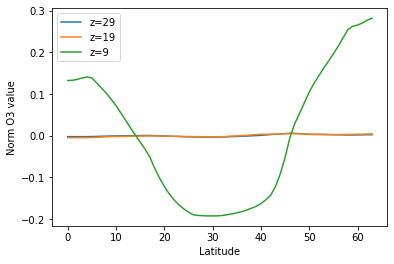

In [98]:
plt.plot(np.mean(INP[NNs][:,:,89,:],axis=(1,2)),label='z=29')
plt.plot(np.mean(INP[NNs][:,:,79,:],axis=(1,2)),label='z=19')
plt.plot(np.mean(INP[NNs][:,:,69,:],axis=(1,2)),label='z=9')
plt.legend()
plt.xlabel('Latitude')
plt.ylabel('Norm O3 value')

Text(0, 0.5, 'Norm O3 value')

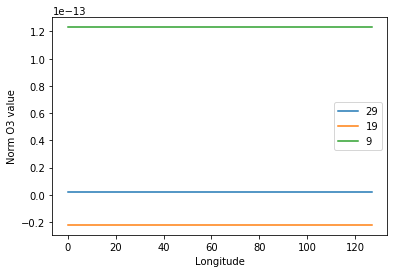

In [99]:
plt.plot(np.mean(INP[NNs][:,:,89,:],axis=(0,2)),label='29')
plt.plot(np.mean(INP[NNs][:,:,79,:],axis=(0,2)),label='19')
plt.plot(np.mean(INP[NNs][:,:,69,:],axis=(0,2)),label='9')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Norm O3 value')

Text(0.5, 0, 'Vertical level')

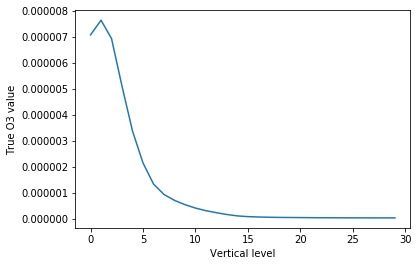

In [97]:
plt.plot(np.mean(INP[NNs][:,:,60:90,:],axis=(0,1,3))*\
         train_gen_O3.input_transform.div[60:90]+\
         train_gen_O3.input_transform.sub[60:90])
plt.ylabel('True O3 value')
plt.xlabel('Vertical level')

In [90]:
inp.div

AttributeError: 'numpy.ndarray' object has no attribute 'div'

In [ ]:
plt.plot(np.mean(INP[NNs][:,:,60:90,:],axis=(0,1,3)))

In [77]:
MSE['2021_01_25_O3'].mean()

255.59680334958662

In [78]:
MSE['2021_01_25_noO3'].mean()

255.3958713068107

In [59]:
p.shape

TensorShape([8192, 120])

In [50]:
# Using md
MSE = {}
VAR = {}
diagno = {}
diagno['truth'] = {}
diagno['pred'] = {}

for iar,itime in enumerate(t_random):
    print('iar=',iar,'/',Nt-1,' & itime',itime,end="\r")
    for i,NNs in enumerate(NNarray):
        if iar==0: MSE[NNs] = {}; VAR[NNs] = {}

        inp, p, truth = md[NNs][data[6:-3]].get_inp_pred_truth(itime)  # [lat, lon, var, lev]
        
        t_geo = md[NNs][data[6:-3]].reshape_ngeo(truth)[:,:,:]
        p_geo = md[NNs][data[6:-3]].reshape_ngeo(p.numpy())[:,:,:]
        
        if iar==0: 
            MSE[NNs][data[6:-3]] = np.mean((t_geo-p_geo)**2,axis=2)
            VAR[NNs][data[6:-3]] = np.var(p_geo,axis=2)
        else: 
            MSE[NNs][data[6:-3]] = np.concatenate((MSE[NNs][data[6:-3]],
                                                   np.mean((t_geo-p_geo)**2,axis=2)),axis=1)
            VAR[NNs][data[6:-3]] = np.concatenate((VAR[NNs][data[6:-3]],
                                                   np.var(p_geo,axis=2)),axis=1)

#         MSE[NNs] = (MSE['samples']*MSE[NNs]+np.mean((p-truth)**2))/(MSE['samples']+1)
#         MSE['samples'] += 1

Text(0.5, 1.0, 'P4K_valid')

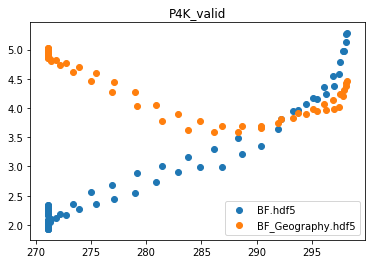

In [51]:
for i,NNs in enumerate(NNarray):
    plt.scatter(np.mean(coor.TS,axis=(0,2)),np.log10(np.mean(MSE[NNs][data[6:-3]],axis=1)),label=NNs)
plt.legend()
plt.title(data[6:-3])

Text(0.5, 1.0, 'P4K_valid')

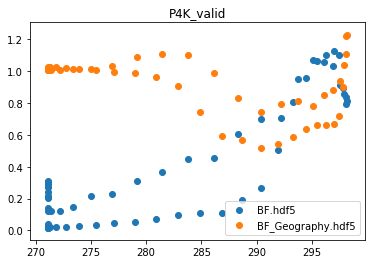

In [52]:
for i,NNs in enumerate(NNarray):
    plt.scatter(np.mean(coor.TS,axis=(0,2)),np.mean(MSE[NNs][data[6:-3]],axis=1)/
                np.mean(VAR[NNs][data[6:-3]],axis=1),label=NNs)
plt.legend()
plt.title(data[6:-3])

In [69]:
coor.TS.shape

(40, 64, 128)

In [15]:
model_aqua.evaluate_generator(valid_gen,steps=100)

19850.45904296875

In [16]:
model_geo.evaluate_generator(valid_gen,steps=100)

215.8908876657486

In [26]:
model = load_model(path_HDF5+save_name+'.hdf5')
model.evaluate_generator(valid_gen)

380.3752907935891

### Check on test dataset (p4k simulation) to test ability of NN to generalize to unseen climate

In [30]:
in_vars = ['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

In [31]:
NORMFILE = 'CI_SP_M4K_NORM_norm.nc'
VALIDFILE = 'CI_SP_P4K_valid.nc'

valid_gen = DataGeneratorClimInv(
    data_fn = path+VALIDFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
    inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div,
    rh_trans=False,t2tns_trans=False,
    lhflx_trans=False,
    scaling=False,
    interpolate=False
)

In [35]:
model = load_model(path_HDF5+save_name+'.hdf5')
model.evaluate_generator(valid_gen)

7919.925893538951

## Retrain BF models for transfer learning

In [16]:
NN

{'BF.hdf5': <tensorflow.python.keras.engine.training.Model at 0x2b1552a2bc18>,
 'BF_Geography.hdf5': <tensorflow.python.keras.engine.training.Model at 0x2b155343c630>}

In [17]:
BF_geog = NN['BF_Geography.hdf5']

In [18]:
BF_geog.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128)               0     

In [19]:
# Where to save the model
path_HDF5 = '/oasis/scratch/comet/tbeucler/temp_project/CBRAIN_models/'
save_name = 'BF_Geog_2020_07_22'

In [20]:
#model.compile(tf.keras.optimizers.Adam(), loss=mse)
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save_pos = ModelCheckpoint(path_HDF5+save_name+'.hdf5',save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
Nep = 10
BF_geog.fit_generator(train_gen, epochs=Nep, validation_data=valid_gen,\
              callbacks=[earlyStopping, mcp_save_pos])

Epoch 1/10
30780/30780 [==============================] - 2630s 85ms/step - loss: 263.0082 - val_loss: 271.8903
Epoch 2/10
30780/30780 [==============================] - 2892s 94ms/step - loss: 259.8000 - val_loss: 271.1745
Epoch 3/10
30780/30780 [==============================] - 2754s 89ms/step - loss: 257.4323 - val_loss: 263.0838
Epoch 4/10
30780/30780 [==============================] - 2782s 90ms/step - loss: 255.5233 - val_loss: 264.0390
Epoch 5/10
30780/30780 [==============================] - 2822s 92ms/step - loss: 253.9055 - val_loss: 266.4253
Epoch 6/10
30780/30780 [==============================] - 2527s 82ms/step - loss: 252.6703 - val_loss: 259.0603
Epoch 7/10
30780/30780 [==============================] - 2931s 95ms/step - loss: 251.3679 - val_loss: 258.7864
Epoch 8/10
30780/30780 [==============================] - 2814s 91ms/step - loss: 250.3712 - val_loss: 262.4873
Epoch 9/10
30780/30780 [==============================] - 2722s 88ms/step - loss: 249.4682 - val_loss: 2

## Transfer Learning experiments

tgb - 7/9/2020 - Use portion<1

### From BF aqua to BF geo

In [17]:
TRAINFILE = 'CI_SP_M4K_train_shuffle.nc'
NORMFILE = 'CI_SP_M4K_NORM_norm.nc'
VALIDFILE = 'CI_SP_M4K_valid.nc'

tgb - 7/23/2020 - Only training last three indices, be careful with saved names!

In [19]:
por_array = [0.01,0.1,1]

In [20]:
Nep = 10

In [21]:
NN = {}
for i,por in enumerate(por_array):
    print('por=',por)
    graph = tf.Graph()
    
    #with tf.Session(graph=graph): # Legacy from tf1
        
    # 1) Define new generators
    train_gen = DataGeneratorClimInv(
    data_fn = path+TRAINFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
    inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div,
    rh_trans=False,t2tns_trans=False,
    lhflx_trans=False,
    scaling=False,
    interpolate=False,
    portion=por
    )

    valid_gen = DataGeneratorClimInv(
    data_fn = path+VALIDFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
    inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div,
    rh_trans=False,t2tns_trans=False,
    lhflx_trans=False,
    scaling=False,
    interpolate=False,
    )

    # 2) Load model
    NN[por] = load_model('/oasis/scratch/comet/tbeucler/temp_project/CBRAIN_models/BF_Aqua_2020_07_22.hdf5') # Load aquaplanet model

    # 3) Define callbacks and save_name of new model
    path_HDF5 = '/oasis/scratch/comet/tbeucler/temp_project/CBRAIN_models/'
    save_name = 'TL_BF_2020_07_23_porindex_'+str(i+3)
    earlyStopping = EarlyStopping(monitor='loss', patience=5, verbose=0, mode='min')
    mcp_save_pos = ModelCheckpoint(path_HDF5+save_name+'.hdf5',save_best_only=True, monitor='loss', mode='min')

    # 4) Train model for Nep epochs and CANNOT save state of best validation loss because
    # it would NOT be consistent with transfer learning scenario
    NN[por].fit_generator(train_gen, epochs=Nep, callbacks=[earlyStopping, mcp_save_pos])

por= 0.01
Epoch 1/10
30780/30780 [==============================] - 678s 22ms/step - loss: 260.9263
Epoch 2/10
30780/30780 [==============================] - 669s 22ms/step - loss: 191.0123
Epoch 3/10
30780/30780 [==============================] - 659s 21ms/step - loss: 159.3961
Epoch 4/10
30780/30780 [==============================] - 659s 21ms/step - loss: 141.7537
Epoch 5/10
30780/30780 [==============================] - 728s 24ms/step - loss: 130.5818
Epoch 6/10
30780/30780 [==============================] - 732s 24ms/step - loss: 122.8509
Epoch 7/10
30780/30780 [==============================] - 731s 24ms/step - loss: 117.2167
Epoch 8/10
30780/30780 [==============================] - 729s 24ms/step - loss: 112.6793
Epoch 9/10
30780/30780 [==============================] - 730s 24ms/step - loss: 109.1834
Epoch 10/10
30780/30780 [==============================] - 727s 24ms/step - loss: 106.4457
por= 0.1
Epoch 1/10
30780/30780 [==============================] - 736s 24ms/step - loss:

tgb - 7/23/2020 - Legacy = Trained por_array = `[0.00001,0.0001,0.001]` already and now only training the last three indices

In [18]:
por_array = [0.00001,0.0001,0.001,0.01,0.1,1]

In [19]:
por_array

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1]

In [20]:
Nep = 10

In [ ]:
NN = {}
for i,por in enumerate(por_array):
    print('por=',por)
    graph = tf.Graph()
    
    #with tf.Session(graph=graph): # Legacy from tf1
        
    # 1) Define new generators
    train_gen = DataGeneratorClimInv(
    data_fn = path+TRAINFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
    inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div,
    rh_trans=False,t2tns_trans=False,
    lhflx_trans=False,
    scaling=False,
    interpolate=False,
    portion=por
    )

    valid_gen = DataGeneratorClimInv(
    data_fn = path+VALIDFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
    inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div,
    rh_trans=False,t2tns_trans=False,
    lhflx_trans=False,
    scaling=False,
    interpolate=False,
    )

    # 2) Load model
    NN[por] = load_model('/oasis/scratch/comet/tbeucler/temp_project/CBRAIN_models/BF_Aqua_2020_07_22.hdf5') # Load aquaplanet model

    # 3) Define callbacks and save_name of new model
    path_HDF5 = '/oasis/scratch/comet/tbeucler/temp_project/CBRAIN_models/'
    save_name = 'TL_BF_2020_07_23_porindex_'+str(i)
    earlyStopping = EarlyStopping(monitor='loss', patience=5, verbose=0, mode='min')
    mcp_save_pos = ModelCheckpoint(path_HDF5+save_name+'.hdf5',save_best_only=True, monitor='loss', mode='min')

    # 4) Train model for Nep epochs and CANNOT save state of best validation loss because
    # it would NOT be consistent with transfer learning scenario
    NN[por].fit_generator(train_gen, epochs=Nep, callbacks=[earlyStopping, mcp_save_pos])

por= 1e-05
Epoch 1/10
30780/30780 [==============================] - 1600s 52ms/step - loss: 300.9996
Epoch 2/10
30780/30780 [==============================] - 728s 24ms/step - loss: 268.3539
Epoch 3/10
30780/30780 [==============================] - 731s 24ms/step - loss: 261.4873
Epoch 4/10
30780/30780 [==============================] - 737s 24ms/step - loss: 257.6655
Epoch 5/10
30780/30780 [==============================] - 726s 24ms/step - loss: 255.0232
Epoch 6/10
30780/30780 [==============================] - 727s 24ms/step - loss: 253.0973
Epoch 7/10
30780/30780 [==============================] - 791s 26ms/step - loss: 251.5846
Epoch 8/10
30780/30780 [==============================] - 737s 24ms/step - loss: 250.1482
Epoch 9/10
30780/30780 [==============================] - 736s 24ms/step - loss: 249.0893
Epoch 10/10
30780/30780 [==============================] - 729s 24ms/step - loss: 248.3081
por= 0.0001
Epoch 1/10
30780/30780 [==============================] - 731s 24ms/step - 